In [1]:
import networkx as nx
import numpy as np
import scanpy as sc
import squidpy as sq
from sklearn.metrics import r2_score
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.data import Data   # Create data containers
from torch_geometric.utils import from_networkx

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from tqdm.auto import tqdm

from torch_geometric.data import Dataset
import torch_geometric.transforms as T

In [2]:
adata = sc.read("../example_files/img_1199670929.h5ad")

In [29]:
adata.obs.class_label.value_counts(normalize=True)*100


class_label
CB Glut       19.332825
Oligo         18.692337
Astro-Epen    16.511628
Vascular      16.473504
MY Glut        9.500572
CB GABA        9.245139
MY GABA        8.086161
Immune         1.463973
P GABA         0.362181
P Glut         0.167747
OEG            0.099123
LQ             0.049562
MB-HB Sero     0.007625
HY GABA        0.003812
HY Glut        0.003812
Name: proportion, dtype: float64

In [68]:
class CustomDataset(Dataset):
    def __init__(self, data, celltypes):
        super(CustomDataset, self).__init__()
        self.graph = data
        self.celltypes = celltypes

    def len(self):
        # Return the number of nodes in the dataset.
        return self.graph.x.shape[0]

    def get(self, idx):
        # Get the data object at index idx.

        # calculate the subgraph
        subset, edge_index, mapping, edge_mask =  k_hop_subgraph(node_idx=[idx], edge_index=self.graph.edge_index, num_hops=1, relabel_nodes=True)

        # subset features
        subgraph_data = self.graph.x[subset].clone()

        # calculate new index of center node
        new_index = torch.nonzero(subset == idx).squeeze()

        # set center node feature to 0
        subgraph_data[new_index] = 0

        # create mask for the center node, to calculate the loss only on the center node
        mask = torch.ones(subgraph_data.shape[0], dtype=torch.bool)
        mask[new_index] = False

        return Data(x=subgraph_data, edge_index=edge_index, y=self.graph.x[idx].view(1, 550), mask=mask, celltype=self.celltypes[idx])

In [69]:
adata.obs.class_label

1015221640100570419     MY GABA
1015221640100590598     MY GABA
1015221640100820600     MY GABA
1015221640100580476     MY GABA
1015221640100580189     MY GABA
                         ...   
1015221640200380165    Vascular
1015221640100580428    Vascular
1015221640100670290    Vascular
1015221640200280189    Vascular
1015221640101020209    Vascular
Name: class_label, Length: 26230, dtype: category
Categories (15, object): ['Astro-Epen', 'CB GABA', 'CB Glut', 'HY GABA', ..., 'Oligo', 'P GABA', 'P Glut', 'Vascular']

In [70]:
sq.gr.spatial_neighbors(adata=adata, radius=20, key_added="adjacency_matrix", coord_type="generic")
edge_index, edge_weight = from_scipy_sparse_matrix(adata.obsp["adjacency_matrix_connectivities"])
x = torch.tensor(adata.X.toarray(), dtype=torch.double)
data = Data(x=x, edge_index=edge_index)
print(f"mean node degree: {edge_index.shape[1]/len(adata):.1f}")

mean node degree: 3.9


In [71]:
#data.num_nodes

In [72]:
#transform = T.Compose([T.RootedEgoNets(1)])

In [73]:

#data.x.shape[0]
dataset = CustomDataset(data=data, celltypes=adata.obs.class_label)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
#data
#edge_index


In [74]:
from torch_geometric.utils import k_hop_subgraph

for datasa in loader:
    print(datasa)
    break


#k_hop_subgraph(node_idx=[14097], edge_index=data#.edge_index, num_hops=1)#, 1, data.x.shape[0], relabel_nodes=True)

#RootedSubgraphDataBatch

DataBatch(x=[176, 550], edge_index=[2, 716], y=[32, 550], mask=[176], celltype=[32], batch=[176], ptr=[33])


In [21]:
#loader = DataLoader([data], batch_size=32, shuffle=True, transform=transform)

In [75]:
loader.dataset

CustomDataset(26230)

In [76]:
# we want to create small subgraph using each node as the center

In [77]:
#torch.tensor(list(subgraphs[0].edges)).t()

In [78]:
# create pytorch geometric dataset from subgraphs
#datasss = [Data(x=torch.tensor(graph.nodes(data="features"), dtype=torch.double), edge_index=torch.tensor(list(graph.edges)).t()) for graph in tqdm(subgraphs)]

#list(subgraphs[0].features)
#daata = [from_networkx(graph, group_node_attrs=['features']) for graph in tqdm(subgraphs)]
#loader = DataLoader(daata, batch_size=32, shuffle=True)
#for daat in daata:
#loader = DataLoader([from_networkx(graph, group_node_attrs=['features'], dtype=torch.double) for graph in tqdm(subgraphs)], batch_size=32, shuffle=True)


#loader = DataLoader([Data(x=x, edge_index=torch.tensor(list(subgraphs[0].edges)).t()) for graph in subgraphs], batch_size=32)

AttributeError: 'GlobalStorage' object has no attribute 'sub_edge_index'

In [80]:
from torch.utils.data import random_split

# Split the data into training, validation, and test sets
train_size = int(0.8 * len(loader.dataset))  # 80% of the data for training
val_size = int(0.1 * len(loader.dataset))  # 10% of the data for validation
test_size = len(loader.dataset) - train_size - val_size  # The rest for testing

train_data, val_data, test_data = random_split(loader.dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [81]:
for data in loader:
    print(data)


DataBatch(x=[148, 550], edge_index=[2, 502], y=[32, 550], mask=[148], celltype=[32], batch=[148], ptr=[33])
DataBatch(x=[136, 550], edge_index=[2, 442], y=[32, 550], mask=[136], celltype=[32], batch=[136], ptr=[33])
DataBatch(x=[152, 550], edge_index=[2, 518], y=[32, 550], mask=[152], celltype=[32], batch=[152], ptr=[33])
DataBatch(x=[178, 550], edge_index=[2, 714], y=[32, 550], mask=[178], celltype=[32], batch=[178], ptr=[33])
DataBatch(x=[161, 550], edge_index=[2, 548], y=[32, 550], mask=[161], celltype=[32], batch=[161], ptr=[33])
DataBatch(x=[147, 550], edge_index=[2, 520], y=[32, 550], mask=[147], celltype=[32], batch=[147], ptr=[33])
DataBatch(x=[170, 550], edge_index=[2, 634], y=[32, 550], mask=[170], celltype=[32], batch=[170], ptr=[33])
DataBatch(x=[193, 550], edge_index=[2, 874], y=[32, 550], mask=[193], celltype=[32], batch=[193], ptr=[33])
DataBatch(x=[172, 550], edge_index=[2, 716], y=[32, 550], mask=[172], celltype=[32], batch=[172], ptr=[33])
DataBatch(x=[157, 550], edge

In [82]:
import torch
from torch_geometric.nn import GCN, summary

#model = GCN(-1, 64, num_layers=2, out_channels=550)
#x = torch.randn(100, 128)
#edge_index = torch.randint(100, size=(2, 20))

#print(summary(model, data.x, data.edge_index))

In [83]:

from torch import nn, optim, Tensor
from torch_geometric.nn import conv



class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)


    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        #print(x.shape)
        #x = self.conv2(x, edge_index).relu()
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        return x

In [ ]:
import random
# Set device for training, macbook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the model and move it to the device

output_dim = 550

# Create the model
model = GCN(-1, 550, output_dim).to(device)

#GCNClassifier(hidden_dim=100, hidden_dim1=100, output_dim=550).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 50

# store losses
train_losses = []
val_losses = []

# store r2 scores
train_r2_scores = []
val_r2_scores = []

best_val_loss = float('inf') # Set initial best validation loss to infinity
patience = 5                # Number of epochs to wait for improvement in validation loss
epochs_no_improve = 0        # Number of epochs with no improvement in validation loss
best_epoch = 0               # Epoch at which we get the best validation loss

# epoch training times
epoch_times = []
#start_time = time.time()

for epoch in range(num_epochs):
    
    # Training phase
    model.train()
    total_train_loss = 0
    train_targets_list = []
    train_outputs_list = []
    model.train()  # Set the model to training mode
    total_loss = 0
    targets_list = []
    outputs_list = []

    for data in loader:
        data = data.to(device)

        outputs = model(data.x.float(), data.edge_index.long())
        loss = criterion(outputs[~data.mask], data.y.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure train loss and r2 score
        total_loss += loss.item() * data.num_graphs
        targets_list.append(data.y.float())
        outputs_list.append(outputs[~data.mask])

    #measure and print r2 and train loss
    train_loss = total_loss / len(loader.dataset)
    train_losses.append(train_loss)
    train_r2 = r2_score(torch.cat(targets_list).cpu().detach().numpy(), torch.cat(outputs_list).cpu().detach().numpy())
    train_r2_scores.append(train_r2)

        # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    val_targets_list = []
    val_outputs_list = []

    for data in val_loader:
        data = data.to(device)

        with torch.no_grad():
            outputs = model(data.x.float(), data.edge_index.long())
            loss = criterion(outputs[~data.mask], data.y.float())

        total_val_loss += loss.item() * data.num_graphs
        val_targets_list.append(data.y.float())
        val_outputs_list.append(outputs[~data.mask])

    # Measure and print validation loss and R2
    val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_r2 = r2_score(torch.cat(val_targets_list).cpu().detach().numpy(), torch.cat(val_outputs_list).cpu().detach().numpy())
    val_r2_scores.append(val_r2)


    # Early stopping and saving best parameters
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), '../models/best_model.pt')
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == patience:
            print(f'Early stopping! Epoch: {epoch}, Best Epoch: {best_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            break

    print(f"Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train r2: {train_r2:.4f},  val loss: {val_loss:.4f}, val r2: {val_r2:.4f}")

In [63]:
# Testing phase
model.eval()
total_test_loss = 0
test_targets_list = []
test_outputs_list = []
test_celltypes_list = []

per_celltype = {}

for data in test_loader:
    data = data.to(device)
    print(data)
    with torch.no_grad():
        outputs = model(data.x.float(), data.edge_index.long())
        loss = criterion(outputs[~data.mask], data.y.float())
    total_test_loss += loss.item() * data.num_graphs
    test_celltypes_list.append(data.celltype)
    test_targets_list.append(data.y.float())
    test_outputs_list.append(outputs[~data.mask])

# Measure and print test loss and R2
test_loss = total_test_loss / len(test_loader.dataset)
test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy())
print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")

DataBatch(x=[61, 550], edge_index=[2, 206], y=[15, 550], mask=[61], celltype=[15], batch=[61], ptr=[16])
Test loss: 0.3549, test r2: 0.2641


In [66]:
len(test_celltypes_list)

1

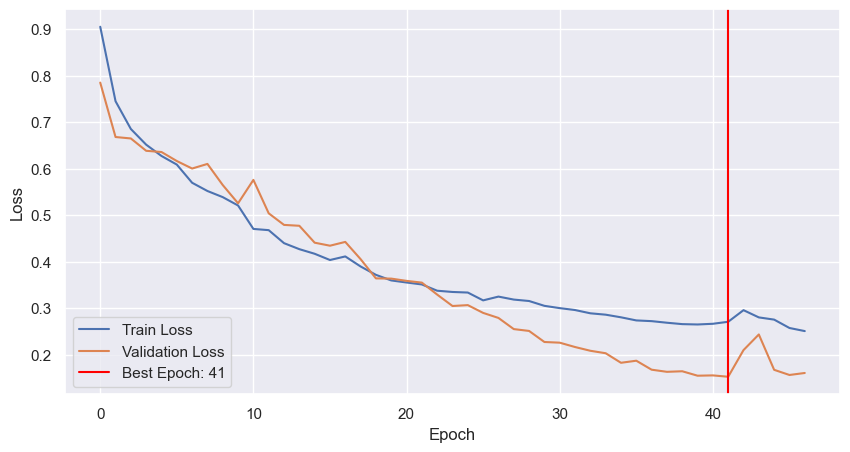

In [64]:
# plot train and validation loss using seaborn, mark best epoch with veritcal line
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axvline(best_epoch, color="red", label=f"Best Epoch: {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
for batch in train_loader:
    print(batch)
    break

DataBatch(x=[167, 550], edge_index=[2, 636], y=[32, 550], mask=[167], batch=[167], ptr=[33])


In [ ]:
sns.scatter(, data.y)